Razlicni grafi za seminarsko 2022


In [17]:
#init code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from csv import DictReader

pn2020 = DictReader(open('data/pn2020.csv', 'rt', encoding='utf-8'), delimiter=";")
pn2019 = DictReader(open('data/pn2019.csv', 'rt', encoding='utf-8'), delimiter=";")
pn2018 = DictReader(open('data/pn2018.csv', 'rt', encoding='utf-8'), delimiter=";")


data = list(pn2020) + list(pn2019) + list(pn2018)
def create_geo_array():
    latitudes = []
    longitudes = []
    for row in data:
        latitude = float(row["GeoKoordinataX"])
        longitude = float(row["GeoKoordinataY"])
        if (longitude == 0.0 or latitude == 0.0):
            continue
        latitudes.append(float(row["GeoKoordinataX"]))
        longitudes.append(float(row["GeoKoordinataY"]))
    return np.array([latitudes, longitudes])

df_geo = create_geo_array()

In [18]:
count_above_proposed = 0
count_above_current = 0
count_above_max = 0
for row in data:
    amount_of_alchocol = float(row["VrednostAlkotesta"].replace(",", "."))
    if amount_of_alchocol > 0.2:
        count_above_proposed += 1
    if amount_of_alchocol > 0.5:
        count_above_proposed += 1
        count_above_current += 1
    if amount_of_alchocol > 1.1:
        count_above_proposed += 1
        count_above_current += 1
        count_above_max += 1
print(f"Nad 0.2: {count_above_proposed}, nad 0.5: {count_above_current}, nad 1.1: {count_above_max}, število nesreč: {len(data)}")

Nad 0.2: $7559, nad 0.5: $3248, nad 1.1: $259, število nesreč: $93711


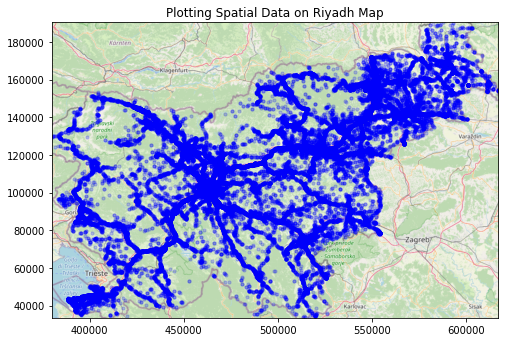

In [19]:
#Geolocational graph

BBox = (df_geo[1].min(),   df_geo[1].max(), df_geo[0].min(), df_geo[0].max())
slo_map = plt.imread('data/map.png')

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_geo[1], df_geo[0], zorder=1, alpha= 0.2, c='b', s=10)

ax.set_title('Plotting Spatial Data on Riyadh Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(slo_map, zorder=0, extent = BBox, aspect= 'equal')
